# ML Model Comparison: LightGBM vs CatBoost

Compare LightGBM and CatBoost on credit risk prediction using the same data and comparable hyperparameters.

In [10]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, log_loss, brier_score_loss
from sklearn.model_selection import train_test_split
from IPython.core.display import HTML

PROJ_ROOT = Path.cwd().parent
if str(PROJ_ROOT) not in sys.path:
    sys.path.append(str(PROJ_ROOT))

from credit_risk_xai.config import FEATURE_CACHE_PATH, ACTIVE_FEATURES
from credit_risk_xai.features.engineer import prepare_modeling_data
from credit_risk_xai.modeling import compute_ece

## 1. Load and Prepare Data

In [2]:
df = pd.read_parquet(FEATURE_CACHE_PATH)
df = df[
    (df["ser_aktiv"] == 1) & 
    (df["sme_category"].isin(["Small", "Medium"])) & 
    (df["knc_kncfall"] == 1) &
    (df["bransch_borsbransch_konv"] != "40.0")
]

X, y = prepare_modeling_data(df)
print(f"Data: {len(X):,} samples, {X.shape[1]} features")
print(f"Default rate: {y.mean()*100:.2f}%")
print(f"Class imbalance: {(y==0).sum()/(y==1).sum():.0f}:1")

Data: 304,149 samples, 22 features
Default rate: 1.76%
Class imbalance: 56:1


In [3]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Identify categorical features for CatBoost
cat_features = [col for col in X.columns if X[col].dtype.name == 'category']
cat_indices = [X.columns.get_loc(col) for col in cat_features]

print(f"Train: {len(X_train):,}, Val: {len(X_val):,}")
print(f"Categorical features: {cat_features}")

Train: 243,319, Val: 60,830
Categorical features: ['sni_group_3digit']


## 2. Train Models

Using comparable settings between LightGBM and CatBoost.

In [5]:
# LightGBM with tuned hyperparameters
lgbm_params = {
    "objective": "binary",
    "n_estimators": 10_000,
    "metric": "logloss",
    "random_state": 42,
    "n_jobs": -1,
    "verbosity": -1,
    "learning_rate": 0.0567,
    "num_leaves": 214,
    "max_depth": 6,
    "min_child_samples": 97,
    "min_child_weight": 0.308,
    "reg_alpha": 4.764,
    "reg_lambda": 9.83e-05,
    "min_split_gain": 0.846,
    "subsample": 0.826,
    "subsample_freq": 3,
    "colsample_bytree": 0.505,
}

lgbm_model = lgb.LGBMClassifier(**lgbm_params)
lgbm_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='logloss',
    callbacks=[
        lgb.early_stopping(stopping_rounds=50, verbose=False),
        lgb.log_evaluation(period=50)
    ]
)

print(f"LightGBM best iteration: {lgbm_model.best_iteration_}")

[50]	valid_0's binary_logloss: 0.0673924
[100]	valid_0's binary_logloss: 0.066455
[150]	valid_0's binary_logloss: 0.0661763
[200]	valid_0's binary_logloss: 0.0660327
LightGBM best iteration: 197


In [13]:
# CatBoost with default settings
catboost_params = {
    "iterations": 10_000,
    "random_seed": 42,
    "verbose": 50,
    "early_stopping_rounds": 50,
    "use_best_model": True,
}

catboost_model = CatBoostClassifier(**catboost_params)
catboost_model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    cat_features=cat_indices,
)

print(f"CatBoost best iteration: {catboost_model.best_iteration_}")

Learning rate set to 0.045216
0:	learn: 0.5972964	test: 0.5973643	best: 0.5973643 (0)	total: 40.4ms	remaining: 6m 44s
50:	learn: 0.0690711	test: 0.0705904	best: 0.0705904 (50)	total: 1.52s	remaining: 4m 57s
100:	learn: 0.0654337	test: 0.0678010	best: 0.0678010 (100)	total: 2.97s	remaining: 4m 50s
150:	learn: 0.0639971	test: 0.0671001	best: 0.0671001 (150)	total: 4.4s	remaining: 4m 46s
200:	learn: 0.0629733	test: 0.0667519	best: 0.0667519 (200)	total: 5.91s	remaining: 4m 48s
250:	learn: 0.0621028	test: 0.0665178	best: 0.0665178 (250)	total: 7.35s	remaining: 4m 45s
300:	learn: 0.0613331	test: 0.0663955	best: 0.0663955 (300)	total: 8.82s	remaining: 4m 44s
350:	learn: 0.0606630	test: 0.0663119	best: 0.0663119 (350)	total: 10.3s	remaining: 4m 42s
400:	learn: 0.0600156	test: 0.0662727	best: 0.0662714 (399)	total: 11.7s	remaining: 4m 39s
450:	learn: 0.0593237	test: 0.0662215	best: 0.0662162 (443)	total: 13.2s	remaining: 4m 39s
500:	learn: 0.0587026	test: 0.0662123	best: 0.0662123 (500)	total:

## 3. Evaluate Models

In [14]:
# Get predictions
lgbm_proba = lgbm_model.predict_proba(X_val)[:, 1]
catboost_proba = catboost_model.predict_proba(X_val)[:, 1]

# Compute metrics
results = {
    'Model': ['LightGBM', 'CatBoost', 'Δ (LGBM - CB)'],
    'AUC': [
        roc_auc_score(y_val, lgbm_proba),
        roc_auc_score(y_val, catboost_proba),
        0
    ],
    'Log Loss': [
        log_loss(y_val, lgbm_proba),
        log_loss(y_val, catboost_proba),
        0
    ],
    'Brier Score': [
        brier_score_loss(y_val, lgbm_proba),
        brier_score_loss(y_val, catboost_proba),
        0
    ],
    'ECE': [
        compute_ece(y_val, lgbm_proba),
        compute_ece(y_val, catboost_proba),
        0
    ],
}

# Compute deltas
for col in ['AUC', 'Log Loss', 'Brier Score', 'ECE']:
    results[col][2] = results[col][0] - results[col][1]

results_df = pd.DataFrame(results)
HTML(results_df.to_html(index=False))

Model,AUC,Log Loss,Brier Score,ECE
LightGBM,0.897160,0.066015,0.015851,0.003224
CatBoost,0.895775,0.066195,0.015882,0.003135
Δ (LGBM - CB),0.001386,-0.000180,-0.000030,0.000089


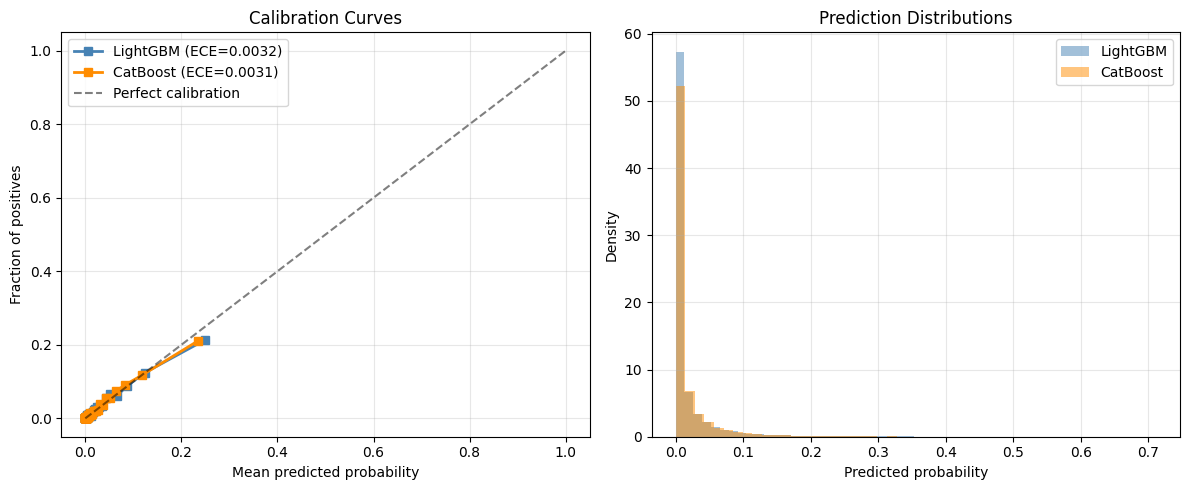

In [15]:
from sklearn.calibration import calibration_curve

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Calibration curves
ax = axes[0]
for name, proba, color in [('LightGBM', lgbm_proba, 'steelblue'), ('CatBoost', catboost_proba, 'darkorange')]:
    fraction_pos, mean_pred = calibration_curve(y_val, proba, n_bins=50, strategy='quantile')
    ece = compute_ece(y_val, proba)
    ax.plot(mean_pred, fraction_pos, 's-', label=f'{name} (ECE={ece:.4f})', color=color, linewidth=2)

ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Perfect calibration')
ax.set_xlabel('Mean predicted probability')
ax.set_ylabel('Fraction of positives')
ax.set_title('Calibration Curves')
ax.legend()
ax.grid(alpha=0.3)

# Prediction distribution
ax = axes[1]
ax.hist(lgbm_proba, bins=50, alpha=0.5, label='LightGBM', color='steelblue', density=True)
ax.hist(catboost_proba, bins=50, alpha=0.5, label='CatBoost', color='darkorange', density=True)
ax.set_xlabel('Predicted probability')
ax.set_ylabel('Density')
ax.set_title('Prediction Distributions')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [16]:
# Compare feature importances
lgbm_importance = pd.DataFrame({
    'feature': X.columns,
    'lgbm': lgbm_model.feature_importances_
})

catboost_importance = pd.DataFrame({
    'feature': X.columns,
    'catboost': catboost_model.feature_importances_
})

importance_comparison = lgbm_importance.merge(catboost_importance, on='feature')
importance_comparison['lgbm_rank'] = importance_comparison['lgbm'].rank(ascending=False)
importance_comparison['catboost_rank'] = importance_comparison['catboost'].rank(ascending=False)
importance_comparison['rank_diff'] = importance_comparison['lgbm_rank'] - importance_comparison['catboost_rank']

HTML(importance_comparison.to_html(index=False))

feature,lgbm,catboost,lgbm_rank,catboost_rank,rank_diff
company_age,287,9.349362,15.0,2.0,13.0
sni_group_3digit,802,1.952870,1.0,20.0,-19.0
ny_kapomsh,357,5.929622,7.5,7.0,0.5
ny_skuldgrd,251,6.570279,18.0,5.0,13.0
ny_solid,156,5.004524,21.0,8.0,13.0
ny_avkegkap,299,3.738654,14.0,11.0,3.0
ny_kasslikv,302,4.519716,13.0,9.0,4.0
ny_nettomarg,352,7.286653,9.5,4.0,5.5
ny_omsf,487,3.246839,2.0,13.0,-11.0
log_total_assets,377,3.999175,5.0,10.0,-5.0
